<a href="https://colab.research.google.com/github/maste473/Spectrum-Guided-Model-Merging---Focused-Fusion-on-Informative-Layers/blob/main/01_ResNet_Vision_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spectrum-Guided Model Merging: ResNet18 on FashionMNIST and KMNIST**

###**Library Imports and Device Configuration**

 In this section, we load the necessary frameworks and configure GPU acceleration if available.

In [1]:
# IMPORT

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy

from torchvision.models import ResNet18_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"


###**Dataset Preparation (Task C and Task D)**

 We define a function to load FashionMNIST (Task C) and KMNIST (Task D). Both datasets are converted from grayscale to RGB to ensure compatibility with ResNet18.

In [ ]:
def get_datasets(batch_size=128):
    transform_gray_to_rgb = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1))
    ])

    # Task C: FashionMNIST
    trainC = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_gray_to_rgb)
    testC  = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_gray_to_rgb)
    loaderC_train = torch.utils.data.DataLoader(trainC, batch_size=batch_size, shuffle=True)
    loaderC_test  = torch.utils.data.DataLoader(testC, batch_size=batch_size, shuffle=False)

    # Task D: KMNIST
    trainD = torchvision.datasets.KMNIST(root="./data", train=True, download=True, transform=transform_gray_to_rgb)
    testD  = torchvision.datasets.KMNIST(root="./data", train=False, download=True, transform=transform_gray_to_rgb)
    loaderD_train = torch.utils.data.DataLoader(trainD, batch_size=batch_size, shuffle=True)
    loaderD_test  = torch.utils.data.DataLoader(testD, batch_size=batch_size, shuffle=False)

    return loaderC_train, loaderC_test, loaderD_train, loaderD_test


###**Model Definition and Training/Evaluation Functions**

 We use ResNet18 as the base model. We include an evaluation function to measure accuracy.


In [ ]:
# Model
def get_model():
    model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(512, 10)
    return model.to(device)

# Finetuning
def finetune(model, loader, epochs=5, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
    return model

###**Weight Spectral Analysis (SNR)**

 Functions to calculate the Signal-to-Noise Ratio (SNR) of the eigenvalues of the weight covariance matrix for each layer.

In [ ]:
def compute_snr(weight):
    W = weight.detach().cpu().numpy()
    if W.ndim > 2:
        W = W.reshape(W.shape[0], -1)
    C = (W @ W.T) / W.shape[1]
    eigvals = np.linalg.eigvalsh(C)
    bulk = np.median(eigvals)
    signal = eigvals.max()
    return signal / (bulk + 1e-8)

def spectrum_snr_per_layer(model):
    snrs = {}
    for name, param in model.named_parameters():
        if "weight" in name and param.ndim >= 2:
            snrs[name] = compute_snr(param)
    return snrs

###**Selective Model Merging Logic**

Here we implement the various strategies to merge the two models (C and D) into a single hybrid model.

In [ ]:
def selective_merge(modelA, modelB, snrA, snrB, threshold, merge_type="standard", alpha=0.5):
    merged = get_model()
    stateA = modelA.state_dict()
    stateB = modelB.state_dict()
    merged_state = merged.state_dict()

    for name in merged_state:
        if name not in snrA:
            merged_state[name].copy_(alpha*stateA[name] + (1-alpha)*stateB[name])
            continue

        if merge_type == "standard":
            merged_state[name].copy_(alpha*stateA[name] + (1-alpha)*stateB[name])

        elif merge_type == "snr_lowA":
            if max(snrA[name], snrB[name]) > threshold:
                merged_state[name].copy_(alpha*stateA[name] + (1-alpha)*stateB[name])
            else:
                merged_state[name].copy_(stateA[name])

        elif merge_type == "snr_lowB":
            if max(snrA[name], snrB[name]) > threshold:
                merged_state[name].copy_(alpha*stateA[name] + (1-alpha)*stateB[name])
            else:
                merged_state[name].copy_(stateB[name])

        elif merge_type == "snr_max":
            if max(snrA[name], snrB[name]) > threshold:
                merged_state[name].copy_(alpha*stateA[name] + (1-alpha)*stateB[name])
            else:
                merged_state[name].copy_(stateA[name] if snrA[name] > snrB[name] else stateB[name])

        elif merge_type == "snr_weighted_dynamic":
            # Calculate dynamic alpha based on SNR ratio            snr_sum = snrA[name] + snrB[name] + 1e-8
            dynamic_alpha = snrA[name] / snr_sum

            if max(snrA[name], snrB[name]) > threshold:
                # If the signal is high, weight the model with higher SNR more heavily                merged_state[name].copy_(dynamic_alpha * stateA[name] + (1 - dynamic_alpha) * stateB[name])
            else:
                # Otherwise, use standard averaging for stability
                merged_state[name].copy_(0.5 * stateA[name] + 0.5 * stateB[name])
        else:
            raise ValueError(f"Unknown merge_type: {merge_type}")

    merged.load_state_dict(merged_state)
    return merged

###**Expert Training**
 We complete the fine-tuning of the two models on their respective tasks.

In [ ]:
loaderC_train, loaderC_test, loaderD_train, loaderD_test = get_datasets()

print("Fine-tuning Model C (FashionMNIST)...")
model_C = finetune(get_model(), loaderC_train)

print("Fine-tuning Model D (KMNIST)...")
model_D = finetune(get_model(), loaderD_train)

print("Evaluating baseline models...")
acc_C_onC = evaluate(model_C, loaderC_test)
acc_D_onD = evaluate(model_D, loaderD_test)
acc_C_onD = evaluate(model_C, loaderD_test)
acc_D_onC = evaluate(model_D, loaderC_test)


Fine-tuning Model C (FashionMNIST)...
Fine-tuning Model D (KMNIST)...
Evaluating baseline models...


###**Merging Experiment Execution**
 We compute the SNR and test various thresholds and merging strategies.

In [ ]:
print("Computing Spectrum SNR...")
snr_C = spectrum_snr_per_layer(model_C)
snr_D = spectrum_snr_per_layer(model_D)

# Added snr_weighted_dynamic to the list of types
merge_types = ["standard", "snr_lowA", "snr_lowB", "snr_max", "snr_weighted_dynamic"]
thresholds = [3.0, 5.0, 15.0, 25.0]
results_taskC = {mtype: [] for mtype in merge_types}
results_taskD = {mtype: [] for mtype in merge_types}
for t in thresholds:
    for mtype in merge_types:
        merged = selective_merge(model_C, model_D, snr_C, snr_D, threshold=t, merge_type=mtype)
        accC = evaluate(merged, loaderC_test)
        accD = evaluate(merged, loaderD_test)
        results_taskC[mtype].append(accC)
        results_taskD[mtype].append(accD)
        print(f"Threshold {t:.1f} | Merge {mtype:20} | Acc C: {accC:.4f} | Acc D: {accD:.4f}")


Computing Spectrum SNR...
Threshold 3.0 | Merge standard             | Acc C: 0.5465 | Acc D: 0.3025
Threshold 3.0 | Merge snr_lowA             | Acc C: 0.5465 | Acc D: 0.3025
Threshold 3.0 | Merge snr_lowB             | Acc C: 0.5465 | Acc D: 0.3025
Threshold 3.0 | Merge snr_max              | Acc C: 0.5465 | Acc D: 0.3025
Threshold 3.0 | Merge snr_weighted_dynamic | Acc C: 0.7329 | Acc D: 0.1155
Threshold 5.0 | Merge standard             | Acc C: 0.5465 | Acc D: 0.3025
Threshold 5.0 | Merge snr_lowA             | Acc C: 0.6451 | Acc D: 0.0842
Threshold 5.0 | Merge snr_lowB             | Acc C: 0.1335 | Acc D: 0.5626
Threshold 5.0 | Merge snr_max              | Acc C: 0.6451 | Acc D: 0.0842
Threshold 5.0 | Merge snr_weighted_dynamic | Acc C: 0.6280 | Acc D: 0.2125
Threshold 15.0 | Merge standard             | Acc C: 0.5465 | Acc D: 0.3025
Threshold 15.0 | Merge snr_lowA             | Acc C: 0.8135 | Acc D: 0.1289
Threshold 15.0 | Merge snr_lowB             | Acc C: 0.1310 | Acc D: 0.8

###**Results Visualization**
 Generating plots to compare performance.


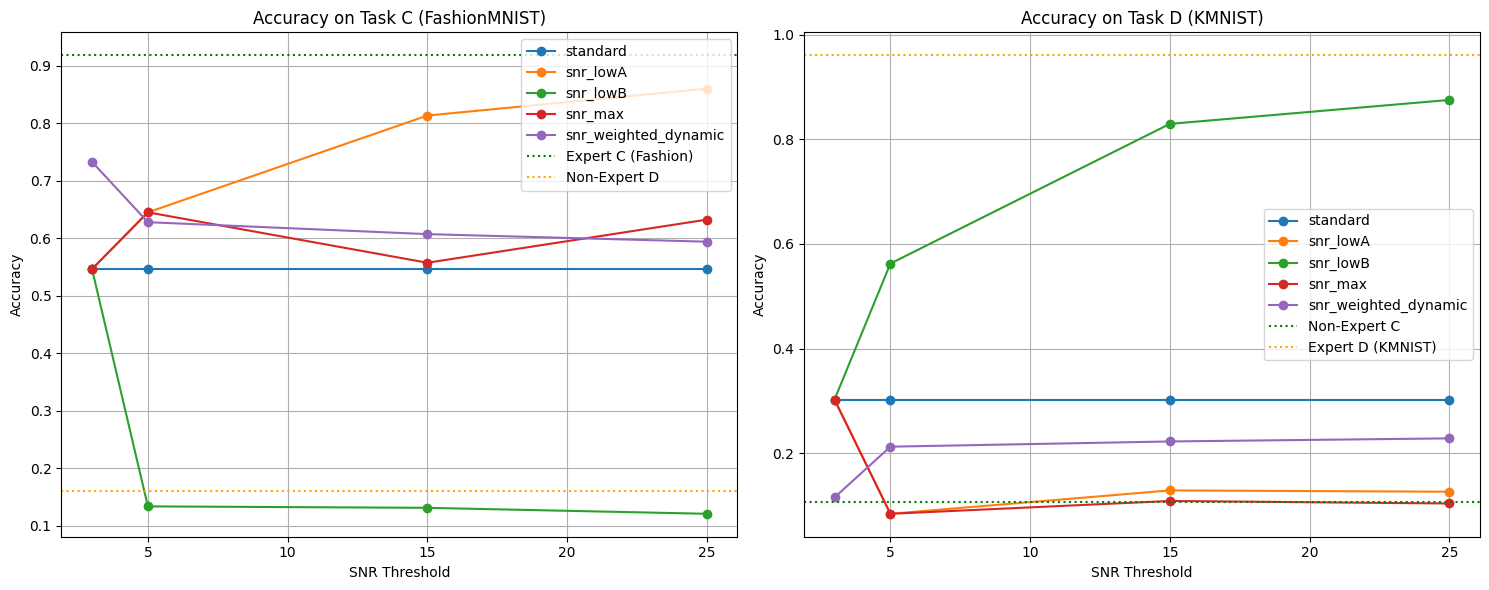

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
for mtype in merge_types:
    plt.plot(thresholds, results_taskC[mtype], marker="o", label=f"{mtype}")
plt.axhline(acc_C_onC, color="green", linestyle=":", label="Expert C (Fashion)")
plt.axhline(acc_D_onC, color="orange", linestyle=":", label="Non-Expert D")
plt.title("Accuracy on Task C (FashionMNIST)")
plt.xlabel("SNR Threshold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
for mtype in merge_types:
    plt.plot(thresholds, results_taskD[mtype], marker="o", label=f"{mtype}")
plt.axhline(acc_C_onD, color="green", linestyle=":", label="Non-Expert C")
plt.axhline(acc_D_onD, color="orange", linestyle=":", label="Expert D (KMNIST)")
plt.title("Accuracy on Task D (KMNIST)")
plt.xlabel("SNR Threshold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()